# Baltimore shootings analysis

By [Christine Zhang](mailto:czhang@baltsun.com) and [Caroline Pate](mailto:cpate@baltsun.com)

The Baltimore Sun conducted the following analysis of Baltimore Police Department Part 1 Victim Based Crime Data posted on [Open Baltimore](https://data.baltimorecity.gov/Public-Safety/BPD-Part-1-Victim-Based-Crime-Data/wsfq-mvij) on October 17, 2018. The report covers incidents between January 1, 2012, and October 13, 2018.

The analysis provided information for the October 18, 2018 Baltimore Sun story titled ["Baltimore's last weekend without a shooting was the weekend Freddie Gray was arrested"](http://www.baltimoresun.com/news/maryland/crime/bs-md-ci-violence-stats-20181018-story.html).

Here were the findings presented in the story:

- There were zero shootings in Baltimore between April 10-12, 2015 — the last weekend in Baltimore which there were no shootings.
- Twelve shootings occurred on Sept. 24, 2016 — the last day that there were as much shootings as the 11 shootings on Oct. 16, 2018.
- Since 2012, the longest stretch of time Baltimore went without a shooting was an eight-day period from February 12-19, 2014.

## Import R data analysis libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('lubridate'))

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

## Data processing:

### Read in BPD Part 1 Victim Based Crime Data for analysis

In [2]:
crime <- read.csv("BPD_Part_1_Victim_Based_Crime_Data.csv", stringsAsFactors = F)

Create a column, `date`, which formats the `CrimeDate` field as a date. Create a new dataframe, `shootings`, which filter the datas to include shootings and homicides for which a firearm was the weapon used.

In [3]:
crime$date <- mdy(crime$CrimeDate)
shootings <- crime %>% filter((Description == 'SHOOTING' | Description == 'HOMICIDE') & Weapon == 'FIREARM') %>%
                       arrange(date) 

### Group the `shootings` dataframe by date to get the number of shootings that occurred on each day

This is saved into another dataframe, `shootings.bydate`. The number of shootings on each day is the sum of the `Total.Incidents` column for each date. We save this into a column called `n`.

In [4]:
shootings.bydate <- shootings %>% group_by(date) %>% summarise(n = sum(Total.Incidents, na.rm = T))

### Add extra columns for days when no shootings occurred and fill the `n` column in with zeros for those days

First, get the time period (minimum date and maximum date) of the `shootings.bydate` dataframe:

In [5]:
time.min <- shootings.bydate$date[1]
time.max <- shootings.bydate$date[length(shootings.bydate$date)]

print(time.min)
print(time.max)

[1] "2012-01-01"
[1] "2018-10-13"


Then, create a dataframe, `all.dates.frame`, containing all the days spanning that time period:

In [6]:
all.dates.frame <- data.frame(list(date = seq(time.min, time.max, by="day")))

Merge this dataframe with the `shootings.bydate` dataframe to get the dates with no shootings. This is saved into a dataframe called `merged.data`:

In [7]:
merged.data <- merge(all.dates.frame, shootings.bydate , all = T)

Extract the day of week using the `wday()` function in the `lubridate` R package. This is saved as the column `dow`:

In [8]:
merged.data$dow <- wday(merged.data$date, label=TRUE)

Finally, fill in the NAs in the `n` column for those days with no shootings with zeros:

In [9]:
merged.data$n <- ifelse(is.na(merged.data$n) == T, 0, merged.data$n)

## Data analysis:

### Finding: There were zero shootings in Baltimore between April 10-12, 2015 — the last weekend in Baltimore which there were no shootings.

The following visualization shows a p-spline fit against daily shootings in Baltimore. Splines are a penalized data-dependent way to smooth data, they can be seen as "honest fits." http://www.math.utep.edu/Faculty/yi/CPS5195f09/victor.pdf The data-dependent aspect minimizes the amount of human-input required. This curve could be improved by choosing a penalization term through cross-validation.

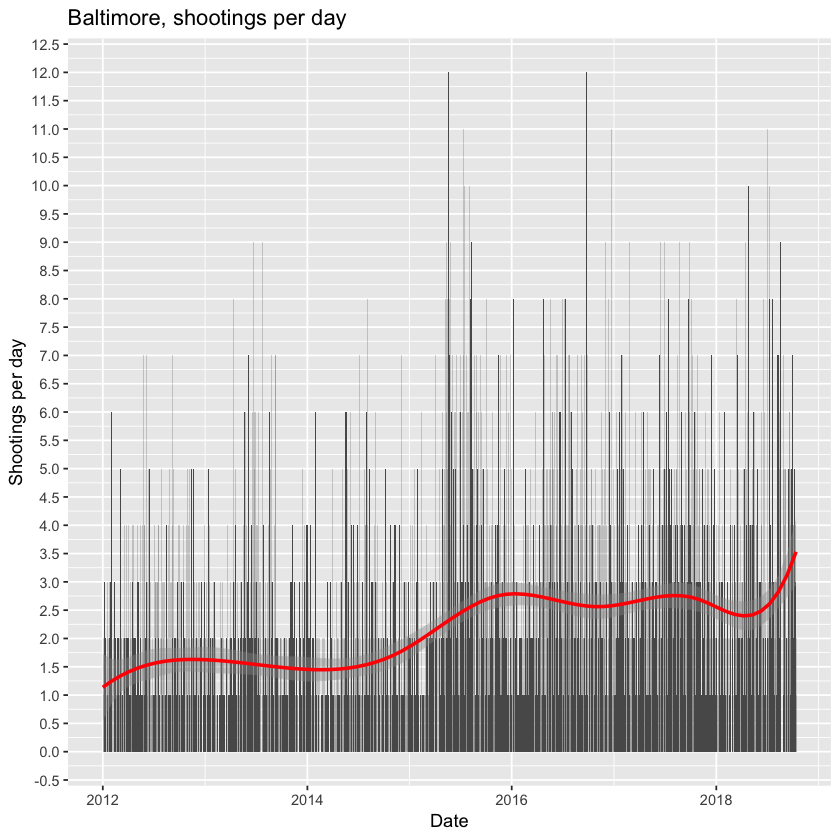

In [10]:
library("ggplot2")
ggplot(merged.data, aes(x = date, y = n)) + 
    geom_bar(stat = "identity") +
    geom_smooth(method = "gam", formula = y ~ s(x, bs = "ps"), colour = "red") +
    ylab("Shootings per day") +
    ggtitle("Baltimore, shootings per day") +
    scale_y_continuous(labels = scales::comma, breaks =  scales::pretty_breaks(20)) +
    xlab("Date")

We can fit both a Poisson and Negative Binomial generalized linear model. The Poisson model is nested within the Negative Binomial model (see http://statwonk.com/negative-binomial-gamma.html). We can test if the extra parameter "theta" has explanatory power worth more than the cost of a more complex model (occam's razor prefering simpler models and explainations).

In [11]:
# install.packages("MASS")
merged.data %>%
  mutate(trend = 1:n()) %>%
  glm(n ~ trend, data = ., family = "poisson") %>%
  logLik() -> poisson_log_likelihood

merged.data %>%
  mutate(trend = 1:n()) %>%
  MASS::glm.nb(n ~ trend, data = .) %>%
  logLik() -> negbin_log_likelihood

logLik(poisson_log_likelihood)
logLik(negbin_log_likelihood)

stat <- as.numeric(2 * (negbin_log_likelihood - poisson_log_likelihood))
 # https://stats.stackexchange.com/a/128640/11509
message("p-value of likelihood ratio test: ", pchisq(stat, df = 5 - 4, lower.tail = FALSE))

'log Lik.' -4771.602 (df=2)

'log Lik.' -4612.035 (df=3)

p-value of likelihood ratio test: 2.23605478238473e-71


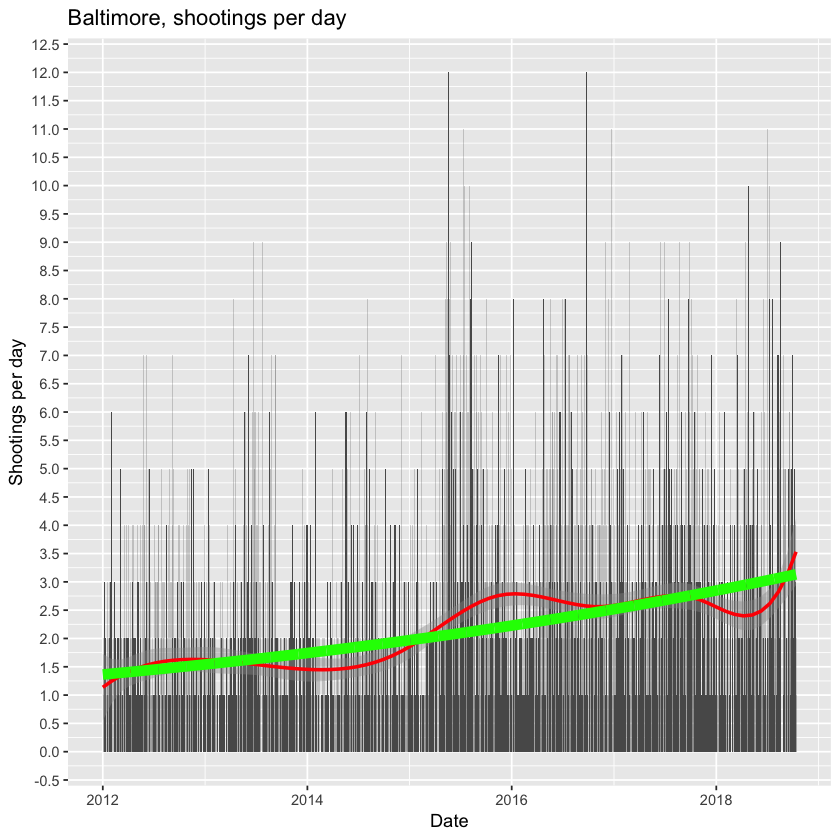

In [12]:
merged.data %>%
  mutate(trend = 1:n()) %>%
  MASS::glm.nb(n ~ trend, data = .) -> nbfit

merged.data %>% 
  mutate(trend = 1:n()) %>% 
  mutate(pred = predict(nbfit, newdata = ., type = "response")) %>%
  ggplot(aes(x = date)) +
  geom_bar(aes(y = n), stat = "identity") +
  geom_smooth(aes(y = n), method = "gam", formula = y ~ s(x, bs = "ps"), colour = "red") +
  geom_line(aes(y = pred), colour = "green", size = 3) + # a prediction from the negative binomial
  ylab("Shootings per day") +
  ggtitle("Baltimore, shootings per day") +
  scale_y_continuous(labels = scales::comma, breaks =  scales::pretty_breaks(20)) +
  xlab("Date")

In [13]:
nbfit %>% summary()


Call:
MASS::glm.nb(formula = n ~ trend, data = ., init.theta = 3.481975764, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1059  -0.8776  -0.2859   0.4103   3.2334  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) 3.099e-01  3.778e-02   8.203 2.35e-16 ***
trend       3.358e-04  2.483e-05  13.522  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(3.482) family taken to be 1)

    Null deviance: 2956.5  on 2477  degrees of freedom
Residual deviance: 2773.8  on 2476  degrees of freedom
AIC: 9230.1

Number of Fisher Scoring iterations: 1


              Theta:  3.482 
          Std. Err.:  0.280 

 2 x log-likelihood:  -9224.070 

We can see a "theta" parameter around 3.48. This indicates significant clustering of shootings. It indicates that some of the shootings are related to each other and could loosely be thought of as a "mass shooting index." higher = less mass shootings to Infinit, lower to 0 = more prone to mass shootings. Yikes.

For each date in the `merged.data` dataframe, calculate the sum of the shootings in the three days prior to that date. This is saved into the variable `lag3_n`.

In [14]:
merged.data <- merged.data %>% mutate(lag3_n = lag(n, 1)+lag(n, 2)+lag(n, 3))

To determine which weekends (defined as the three-day period from Friday to Sunday) saw no shootings, filter `merged.data` to include 0 for `n` and Monday for `dow`.

In [15]:
mondays <- merged.data %>% filter(lag3_n == 0 & dow == 'Mon') 

In [16]:
mondays

date,n,dow,lag3_n
2012-01-16,3,Mon,0
2013-02-18,1,Mon,0
2013-03-25,1,Mon,0
2013-07-22,9,Mon,0
2014-02-17,0,Mon,0
2014-03-24,1,Mon,0
2015-02-09,1,Mon,0
2015-04-13,2,Mon,0


There were no shootings over the three day period encompassing Friday 2015-04-10, Saturday 2015-04-11, Sunday 2015-04-12. (There were 2 shootings on Monday 2015-04-13.)

### Finding: Twelve shootings occurred on Sept. 24, 2016 — the last day that there were as much shootings as the 11 shootings on Oct. 16, 2018.

Use `table()` to view the distribution of shooting incidents in the `shootings.bydate` dataframe.

In [17]:
table(shootings.bydate$n)


  1   2   3   4   5   6   7   8   9  10  11  12 
641 524 331 212 113  76  48  21  13   4   3   2 

Filter to see the days with the maximum `n`, which in this case is 12.

In [18]:
shootings.bydate %>% filter(n == 12)

date,n
2015-05-20,12
2016-09-24,12


There were 12 shootings on Sept. 24, 2016.

### Finding: Since 2012, the longest stretch of time Baltimore went without a shooting was an eight-day period from February 12-19, 2014.

Create a variable, `days_between_shootings`, that represents the number of days between the dates in the `shootings.bydate` dataframe. This is calculated using the `difftime()` function in base R.

In [19]:
shootings.bydate$days_between_shootings <- difftime(shootings.bydate$date, lag(shootings.bydate$date)) - 1

In [20]:
shootings.bydate %>% filter(!is.na(days_between_shootings)) %>% arrange(desc(days_between_shootings)) %>% head()

date,n,days_between_shootings
2014-02-20,1,8 days
2018-08-26,5,7 days
2014-03-24,1,6 days
2015-02-09,1,6 days
2013-03-25,1,5 days
2013-07-22,9,5 days


Check this with the `merged.data` dataframe:

In [21]:
merged.data %>% filter(year(date) == 2014 & month(date) == 2) %>% select(date, n)

date,n
2014-02-01,0
2014-02-02,0
2014-02-03,1
2014-02-04,0
2014-02-05,2
2014-02-06,0
2014-02-07,2
2014-02-08,1
2014-02-09,0
2014-02-10,1


The eight-day period from 2014-02-12 to 2014-02-19 had zero recorded shootings.